# I built a model that automatically classifies text as either having a positive or negative sentiment. 

In [40]:
#I created these classes and functions to keep the data from being messy
class Sentiment:
    NEGATIVE = 'NEGATIVE'
    NEUTRAL = 'NEUTRAL'
    POSITIVE = 'POSITIVE'

class Review:
    def __init__(self, text, score):
        self.text = text #review text
        self.score = score #review score
        self.sentiment = self.get_sentiment() #review sentiment: negative, neutral and positive
        
    def get_sentiment(self): #we will have 3 sentiments based on the reviews' scores
        if self.score <= 2:
            return Sentiment.NEGATIVE
        elif self.score == 3:
            return Sentiment.NEUTRAL
        else: #the score higher than 4
            return Sentiment.POSITIVE
        
import random
class ReviewContainer: 
    #functions to make the number of postive and negative sentiments equal
    #-->improve the predictions for negative sentiments since the postive outnumber the negative too much
    
    def __init__(self, reviews):
        self.reviews = reviews
        
    def get_text(self):
        return [x.text for x in self.reviews]
    def get_sentiment(self):
        return [x.sentiment for x in self.reviews]
    
    def evenly_distribute(self):
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
        positive_shrunk = positive[:len(negative)] #restrict the number of positive reviews
        
        self.reviews = positive_shrunk + negative #we have a new list containing equal positive and negative reviews
        random.shuffle(self.reviews) #make sure negative and positive reviews are radom
        

## Load the Data

In [41]:
# I used amazon reviews as the training data
import json

file_name = 'D:\Books_small_10000.json'

reviews = [] #create a list

with open(file_name) as f:
    for line in f:
        review = json.loads(line)
        reviews.append(Review(review['reviewText'], review['overall'])) #list contain reviewText and Overall


# Train test split

In [42]:
from sklearn.model_selection import train_test_split

training, test = train_test_split(reviews, test_size = 0.33, random_state = 42)

#I changed to modify with the reviews which contain equal positive and negative sentiment

train_container = ReviewContainer(training)
test_container = ReviewContainer(test)


In [43]:

train_container.evenly_distribute() #use the function to distribute positive and negative reviews equally 
train_x = train_container.get_text() #text
train_y = train_container.get_sentiment() #sentiment

test_container.evenly_distribute() 
test_x = test_container.get_text()
test_y = test_container.get_sentiment()

#train_y.count(Sentiment.POSITIVE)
#train_y.count(Sentiment.NEGATIVE)


# Numerical Vectors 

In [44]:
#convert text into numerical vectors for the following classification and prediction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#The TfidfVectorizer helps me choose the key words that define a either good or bad book, instead of scanning the whole text

vectorizer = TfidfVectorizer()

train_x_vectors = vectorizer.fit_transform(train_x)
test_x_vectors = vectorizer.transform(test_x)

train_x_vectors.toarray()


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.15491338,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Model Selection & Classification

## SVC


In [48]:

from sklearn.svm import SVC

clf_svm = SVC(kernel = 'linear', gamma='auto')
clf_svm.fit(train_x_vectors, train_y)

clf_svm.predict(test_x_vectors[0]) #predict the first review


array(['NEGATIVE'], dtype='<U8')

# Decision Tree


In [47]:

from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier()
clf_tree.fit(train_x_vectors, train_y)

clf_tree.predict(test_x_vectors[0]) #predict the first review


array(['POSITIVE'], dtype='<U8')

# Log Regression


In [49]:

from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression()

clf_log.fit(train_x_vectors, train_y)
clf_log.predict(test_x_vectors[0]) #predict the first review


array(['NEGATIVE'], dtype='<U8')

# Mean Accuracy

In [50]:
# To see how much my predictions fit the real sentiment in the database

print(clf_log.score(test_x_vectors, test_y))
print(clf_tree.score(test_x_vectors, test_y))
print(clf_svm.score(test_x_vectors, test_y))

0.8052884615384616
0.6466346153846154
0.8076923076923077


# F1 Score 


In [51]:
#I used F1 Score to measure the accuracy of my prediction 

#Before adding "evenly_distribute" functions, 
#I had a very low score in predicting the negative sentiment 
#since the positive sentiments outnumbered the negative ones too much

from sklearn.metrics import f1_score

print(f1_score(test_y, clf_log.predict(test_x_vectors), average=None, labels =[Sentiment.POSITIVE,Sentiment.NEGATIVE]))
print(f1_score(test_y, clf_tree.predict(test_x_vectors), average=None, labels =[Sentiment.POSITIVE,Sentiment.NEGATIVE]))
print(f1_score(test_y, clf_svm.predict(test_x_vectors), average=None, labels =[Sentiment.POSITIVE,Sentiment.NEGATIVE]))

#I will choose the log regression and svc models since they have higher accuracy rates

[0.80291971 0.80760095]
[0.64233577 0.65083135]
[0.80582524 0.80952381]


# Here is the fun part!!!! Let's see our model in action!!!

In [52]:
test_set = ['great', 'bad book do not buy', 'horrible waste of time', 'very fun', 'brilliant']
new_test = vectorizer.transform(test_set) #transfer the text above into numerical vectors

print(clf_log.predict(new_test))
print(clf_svm.predict(new_test))


['POSITIVE' 'NEGATIVE' 'NEGATIVE' 'POSITIVE' 'POSITIVE']
['POSITIVE' 'NEGATIVE' 'NEGATIVE' 'POSITIVE' 'POSITIVE']


In [53]:
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf'), 'C':(1,4,8,16,25)}

from sklearn import svm, datasets
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(train_x_vectors, train_y)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': (1, 4, 8, 16, 25), 'kernel': ('linear', 'rbf')})

In [54]:
import pickle
with open('D:\Machine Learning/Book Reviews/book_sentiment_classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [55]:
with open('D:\Machine Learning/Book Reviews/book_sentiment_classifier.pkl', 'rb') as f:
    loaded_clf = pickle.load(f)
    

In [56]:
print(test_x[0])

loaded_clf.predict(test_x_vectors[0])

Was not well written. It was interesting to read but other than that I think I could have watched movie and been just as well off...


array(['NEGATIVE'], dtype='<U8')

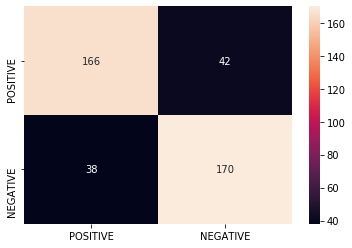

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib as plt

y_pred = clf.predict(test_x_vectors)

labels = [Sentiment.POSITIVE, Sentiment.NEGATIVE]

cm = confusion_matrix(test_y, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sns.heatmap(df_cm, annot=True, fmt='d')

Conclusions & Discussion: 
- The predictions overall are good by using Log Regression and SVC models.
- Outcomes are improved, mostly in the negative reviews predictions, increasing to ~0.79 (instead of ~0.29) after I implemented the "evenly_distribute" function and imported "TfidfVectorizer".
- The key lesson here is that we have to make sure the distribution of each catagory (negative and positive sentiments in this case) is as equal as possible. 